# Rift Valley Fever ABM Model

This is the ABM model to predict an outbreak in Uganda and to test the effect of intervention

## Initialize the RVF Model

Set parameters for RVF

Starsim 0.3.3 (2024-04-16) — © 2023-2024 by IDM
Initializing sim with 1000 agents
  Running 2000.0 ( 0/50) (1.03 s)  ———————————————————— 2%
  Running 2010.0 (10/50) (1.24 s)  ••••———————————————— 22%
  Running 2020.0 (20/50) (1.31 s)  ••••••••———————————— 42%
  Running 2030.0 (30/50) (1.40 s)  ••••••••••••———————— 62%
  Running 2040.0 (40/50) (1.52 s)  ••••••••••••••••———— 82%


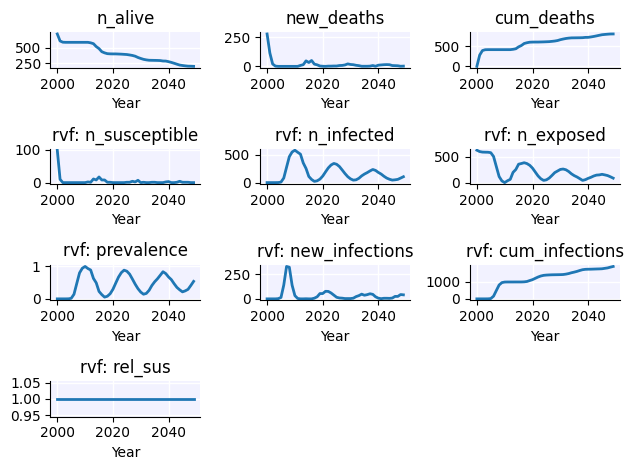

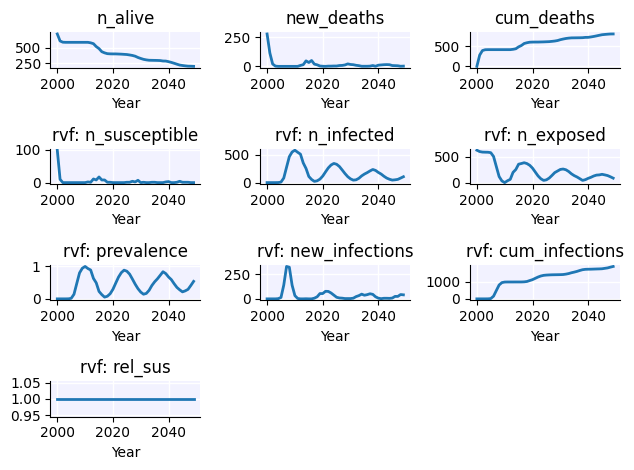

In [1]:
import rvf
import sciris as sc
import starsim as ss

rvf_disease = rvf.rvf()

pars = sc.objdict(
    n_agents = 1000,
    networks = 'random',
)
sim = ss.Sim(pars=pars, diseases=rvf_disease)
sim.run()
sim.plot()

In [ ]:
import rvf

# Set default parameters
default_pars = sc.objdict(
    beta = rvf.pars.beta,
    gamma = 1 - rvf.pars.p_death,
    n_contacts = 20,
    distance = 0.5, # The distance over which people form contacts
    I0 = 1, # Number of cows initially infected
    N = 1000, # Total population size
    maxtime = 100, # How long to simulate for
    npts = 100, # Number of time points during the simulation
    seed = 3, # Random seed to use for reproducible yet random results -- Note, not all seeds "take off"
    colors = sc.objdict(S='darkgreen', I='gold', R='skyblue'),
    save_movie = False, # Whether to save the movie (slow)
)

class Cow(rvf):
    """
    Define each cow (agent) in SimpleABM

    They have three (mutually exclusive) states: susceptible (S), infected (I),
    recovered (R). They also have x,y coordinates for plotting.
    """

    def __init__(self, pars):
        self.pars = pars
        self.S = True # People start off susceptible
        self.I = False
        self.R = False
        # Use data to update location 
        self.x = np.random.rand()
        self.y = np.random.rand()

    #def infect(self):
     #   self.S = False
     #   self.I = True

    #def recover(self):
     #   self.I = False
     #   self.R = True

    #def check_infection(self, other):
     #   pars = self.pars
      #  if self.S: # A person must be susceptible to be infected
       #     if other.I: # The other person must be infectious
        #        if np.random.rand() < pars.beta*pars.dt: # Infection is probabilistic
         #           self.infect()

    #def check_recovery(self):
     #   pars = self.pars
      #  if self.I: # A person must be infected to recover
       #     if np.random.rand() < pars.gamma*pars.dt: # Recovery is also probabilistic
        #        self.recover()


class Sim(rvf):
    """
    Define the simulation
    """

    def __init__(self, **kwargs):
        pars = sc.mergedicts(default_pars, kwargs) # Parameters to use
        pars.dt = pars.maxtime/pars.npts # Timestep length
        self.T = np.arange(pars.npts)
        self.time = self.T*pars.dt
        self.pars = pars
        self.initialize()

    def initialize(self):
        """ Initialize everything (sim can be re-initialized as well) """
        pars = self.pars

        # Initilaize people and the network
        np.random.seed(pars.seed)
        self.people = [Person(pars) for i in range(pars.N)] # Create all the people
        for person in self.people[0:pars.I0]: # Make the first I0 people infectious
            person.infect() # Set the initial conditions
        self.make_network()

        # Initial conditions
        self.S = np.zeros(pars.npts)
        self.I = np.zeros(pars.npts)
        self.R = np.zeros(pars.npts)
        self.S_full = []
        self.I_full = []
        self.R_full = []

    def get_xy(self):
        """ Get the location of each agent """
        x = np.array([p.x for p in self.people])
        y = np.array([p.y for p in self.people])
        return x,y

    # This method:
    # 1. Calculates the Euclidean distance between each possible pair of agents
    # 2. Computes a random number for each possible pair
    # 3. Sorts the pairs by distance divided by the random numbers
    # 4. Selects the top N*n_contacts/2 pairs to form connections
    # 5. Sets this as self.contacts
    def make_network(self):
        """ Create the network by pairing agents who are close to each other """
        pars = self.pars      # Here we store self.pars as 'pars' as a design choice for efficiency, as the 'pars' parameter is called so many times in this function
        x,y = self.get_xy()      # Retrieve the x and y coordinates of all the agents
        dist = np.zeros((pars.N, pars.N))      # Set a 2-dimensional array (NxN) to store the distances between every agent
        for i in range(pars.N):      
            dist[i,:] = 1 + ((x - x[i])**2 + (y - y[i])**2)**0.5/pars.distance      # Calculate the distance between agent i and every other agent. Adding 1 normalizes the calculated distances, and dividing by pars.distance scales the calculated distance by this factor
            dist[i,i] = np.inf      # We set the distance between an agent and itself to infinity to exclude the current agent from being considered as a neighbor to itself

        rnds = np.random.rand(pars.N, pars.N)      # We generate an NxN array of random numbers
        ratios = dist/rnds      # This creates an array of ratios where each element is the distance between two agents divided by a random number
        order = np.argsort(ratios, axis=None)      # We sort the ratios array by the distances in ascending order, flattening the array into a 1D array while keeping track of the original indices
        inds = order[0:int(pars.N*pars.n_contacts/2)]      # Here, the first N * n_contacts / 2 indices from the sorted array (order) are selected
        contacts = np.unravel_index(inds, ratios.shape)      # The selected indices (inds) are converted into coordinate pairs using np.unravel_index.
        self.contacts = np.vstack(contacts).T      # Finally, the converted coordinate pairs are vertically stacked into a 2D array (np.vstack), and then transposed (T) to swap rows and columns. This creates an array where each row represents a pair of agents that are selected as contacts

    # EXERCISE: write a method "check_infections" that checks for infections among pairs of people in the contacts
    def check_infections(self):
        """ Check which agents become infected """
        # Using self.contacts, which is a 2D array of all agent contacts, we check whether each of these people in a relationship is infected
       # p1 and p2 represent the indices of two agents in a contact pair (column 1 and column 2)
        for p1,p2 in self.contacts:
            person1 = self.people[p1] # Set person1 and person2 as the People objects in contact
            person2 = self.people[p2]
            person1.check_infection(person2) # Check to see if person 2 will infect person 1
            person2.check_infection(person1) # Check to see if person 1 will infect person 2

    def check_recoveries(self):
        """ Check which agents recover """
        for person in self.people:
            person.check_recovery()

    def count(self, t): ### This combines the functions count and check_states that we had defined in the last tutorial
        """ Count the number of agents in each state """
        this_S = [] # Arrays to store the indices of people who are S, I, or R
        this_I = []
        this_R = []
        for i,person in enumerate(self.people): # Check to see if each person is S,I,R and add their index (from the self.people array) to the this_ array defined above
            if person.S: this_S.append(i)
            if person.I: this_I.append(i)
            if person.R: this_R.append(i)

        self.S[t] += len(this_S) # Add the number of susceptible agents (at this point in time) to the self.S array
        self.I[t] += len(this_I)
        self.R[t] += len(this_R)

        self.S_full.append(this_S) # Add the array of susceptible people's indices (at this point in time) to the self.S_full array
        self.I_full.append(this_I)
        self.R_full.append(this_R)

    def run(self):
        """ Run the simulation by integrating over time """
        for t in self.T:
            self.check_infections() # Check which infectious occur
            self.check_recoveries() # Check which recoveries occur
            self.count(t) # Store results

    def plot(self):
        """ Plot numbers of S, I, R over time """
        pl.figure()
        cols = self.pars.colors
        pl.plot(self.time, self.S, label='Susceptible', c=cols.S)
        pl.plot(self.time, self.I, label='Infected', c=cols.I)
        pl.plot(self.time, self.R, label='Recovered', c=cols.R)
        pl.legend()
        pl.xlabel('Time')
        pl.ylabel('Number of people')
        pl.ylim(bottom=0)
        pl.xlim(left=0)
        pl.show()

    def animate(self, pause=0.01, save=False):
        """ Create an animation of the infection as it spreads across the network """
        anim = sc.animation()
        fig,ax = pl.subplots()
        x,y = self.get_xy()
        for p in self.contacts:
            p0 = p[0]
            p1 = p[1]
            pl.plot([x[p0], x[p1]], [y[p0], y[p1]], lw=0.5, alpha=0.1, c='k')

        handles = []
        for t in self.T[:-1]:
            if pl.fignum_exists(fig.number):
                for h in handles:
                    h.remove()
                handles = []
                counts = sc.dictobj()
                inds = sc.dictobj()
                for key,fullkey in [('S', 'S_full'), ('I', 'I_full'), ('R', 'R_full')]:
                    inds[key] = self[fullkey][t]
                    counts[key] = len(inds[key])
                    this_x = x[inds[key]]
                    this_y = y[inds[key]]
                    h = ax.scatter(this_x, this_y, c=self.pars.colors[key])
                    handles.append(h)
                title = f't={t}, S={counts.S}, I={counts.I}, R={counts.R}'
                pl.title(title)
                pl.pause(pause)
                if save:
                    anim.addframe()

        if save:
            anim.save(f'network_{self.pars.distance}.mp4')

if __name__ == '__main__':

    # Create and run the simulation
    sim = Sim()
    sim.run()
    sim.plot()
   


## Interventions

In [ ]:
import numpy as np # Math
import sciris as sc # Utilities
import pylab as pl # Plotting
import starsim as ss # ABM


class vaccination(ss.Intervention):  # Create a new, generic treatment intervention

    def __init__(self, prob=0.12, mean_dur_infection=9):
        super().__init__() # Initialize the intervention
        self.prob = prob # Store the probability of vaccination
        self.dur_infection = ss.normal(mean_dur_infection, 1)  # Store the duration of infection

    def apply(self, sim):
        rvf = sim.diseases.rvf

        # Define  who is eligible for vaccination
        eligible_ids = sim.people.uid[rvf.ti_infected == sim.ti]  # People are eligible for treatment if they have just started exhibiting symptoms
        n_eligible = len(eligible_ids) # Number of people who are eligible

        # Define who receives  vaccination
        is_vaccinated = np.random.rand(n_eligible) < self.prob  # Define which of the n_eligible people get treated by comparing np.random.rand() to self.p
        vaccinated_ids = eligible_ids[is_vaccinated]  # Pull out the IDs for the people receiving the treatment

        # vaccinated people will have a new disease progression
        dur_inf = self.dur_infection.rvs(vaccinated_ids)  # Sample duration of infection by generating random variables (RVS) drawn from the distribution of durations

        # Determine who dies and who recovers and when
        will_die = rvf.pars.p_death.rvs(treat_ids)  # Sample probability of dying
        dead_uids = vaccinated_ids[will_die]  # Pull out the IDs of people who die
       # recover_uids = vaccinated_ids[~will_die]  # Pull out the IDs of people who recovery
        rvf.ti_dead[dead_uids] = rvf.ti_infected[dead_uids] + dur_inf[will_die] / sim.dt  # Set the time of death
        rvf.ti_recovered[recover_uids] = rvf.ti_infected[recover_uids] + dur_inf[~will_die] / sim.dt  # Set the time of recovery


class Quarantine(ss.Intervention):
    def __init__(self, prob=1, rel_trans=0, delay=0):
        super().__init__() # Initialize the intervention
        self.prob = prob # Store the probability of quarantining
        self.rel_trans = rel_trans  # Relative transmissibility of people in quarantine
        self.delay = delay  # Delay between exposure and being put into quarantine

    def apply(self, sim):
        rvf = sim.diseases.rvf

        # Define  who is eligible for vaccination
        eligible_ids = sim.people.uid[(rvf.ti_exposed - self.delay) == sim.ti]  # People are eligible for quarantine after a delay 
        n_eligible = len(eligible_ids)  # Number of eligible people

        # Define who is quarantined
        in_quarantine = np.random.rand(n_eligible) < self.prob  # Define which of the n_eligible people are quarantined by comparing np.random.rand() to self.p
        quar_ids = eligible_ids[in_quarantine]  # Pull out the IDs for the people going into quarantine

        # Quarantined people will have a reduced relative transmissibility
        rvf.rel_trans[quar_ids] = self.rel_trans


def make_run_sim(delay=0, n_contacts=7.41, beta=0.33, treated_dur_infection=8, do_plot=True, verbose=0.1):

    # Make the interventions
    vaccination = vaccination(mean_dur_infection=vaccinated_dur_infection)  # Create the specific treatment
    quarantine = Quarantine(delay=delay)  # Create the specific quarantine

    # Make the parameters
    pars = dict(start=0, end=30, dt=1.0, verbose=verbose)  # Define the parameters of the simulation
    n_contacts = n_contacts  # Define the daily number of contacts that a person has
    beta = beta  # Define the probability of an infected person transmitting to a susceptible person

    # In tutorial 5.2, the 'pars' dictionary also oncluded the diseases and the network. It looked like this:
    #    pars = dict(start=0, end=50, dt=1.0, diseases='sis', networks='random')
    # In this tutorial, we will see how to change some of the parameters of the disease and network
    # Rather than putting them in the pars dictionary, we provide them separately to the simulation. 

    # Define "baseline" and "intervention" sims: without any interventions, with treatment, and with quarantine
    baseline = ss.Sim(
        pars, 
        networks=ss.RandomNet(pars=dict(n_contacts=ss.poisson(n_contacts))),
        diseases = ss.rvf(pars=dict(beta=beta))
        )
    vaccinated_sim = ss.Sim(
        pars, 
        networks=ss.RandomNet(pars=dict(n_contacts=ss.poisson(n_contacts))),
        diseases = ss.rvf(pars=dict(beta=beta)),
        interventions=vaccinated
        )
    quar_sim = ss.Sim(
        pars,
        networks=ss.RandomNet(pars=dict(n_contacts=ss.poisson(n_contacts))),
        diseases = ss.rvf(pars=dict(beta=beta)),
        interventions=quarantine
        )

    # Run the three simulations
    baseline.run()
    vaccinated_sim.run()
    quar_sim.run()

    # Pull out results to plot
    tvec = baseline.yearvec
    n_inf_base = baseline.results.rvf.n_infected
    n_inf_vaccinated = vaccinated_sim.results.rvf.n_infected
    n_inf_quar = quar_sim.results.rvf.n_infected

    new_inf_base = baseline.results.rvf.new_infections
    new_inf_vaccinated = vaccinated_sim.results.rvf.new_infections
    new_inf_quar = quar_sim.results.rvf.new_infections

    if do_plot:  # Whether or not to make the plot
        # Create the figure
        pl.figure()

        # Plot number of people infected
        pl.subplot(2,1,1)  # Create the first panel in the plot
        pl.title('Number of people infected')
        pl.plot(tvec, n_inf_base, 'o-', label='Baseline')  # Plot baseline
        pl.plot(tvec, n_inf_vaccinated, 'o-', label='vaccination')  # Plot treatment
        pl.plot(tvec, n_inf_quar, 'o-', label='Quarantine')  # Plot quarantine
        pl.legend()

        # Plot number of new infections
        pl.subplot(2,1,2) # Create the second panel in the plot
        pl.title('New infections')
        pl.plot(tvec, new_inf_base, 'o-', label='Baseline') # Plot baseline
        pl.plot(tvec, new_inf_vaccinated, 'o-', label='vaccination') # Plot treatment
        pl.plot(tvec, new_inf_quar, 'o-', label='Quarantine') # Plot quarantine
        pl.legend()

        sc.figlayout()
        pl.show()

    # Calculate and display the number of infections averted
    averted_by_treatment = n_inf_base.sum() - n_inf_treat.sum()
    averted_by_quarantine = n_inf_base.sum() - n_inf_quar.sum()
    print(f'Number of infections averted by vaccination: {averted_by_vaccination}')
    print(f'Number of infections averted by quarantine: {averted_by_quarantine}')
    print(f'Percentage of infections averted by vaccination: {(averted_by_vaccination)/n_inf_base.sum()}')
    print(f'Percentage of infections averted by quarantine: {(averted_by_quarantine)/n_inf_base.sum()}')


# Make, run, and plot the simulation
make_run_sim()


## Problem 2

Explore the properties of the interventions:

- People are put into quarantine with a delay (`delay`). Try running the intervention with `delay = 1` and interpret your result.
- What recommendation would you make to the goverment about the treatment vs the quarantine policy?

## Solution 2

### Explore the properties of the interventions

In [ ]:
make_run_sim(delay=1)

## Problem 3

Exploring the required treatment characteristics:

- In the example above, we assumed that the treatment reduced the mean duration of infection to 5 days. The manufacturers of the treatment are now saying that they may not be able to guarantee this, and they are wondering what level of reduction would be needed for the treatment to be recommended by the World Health Organisation. The WHO has replied that if the treatment reduces infections by 10% with 50% coverage, this would be enough. Find the treatment charactersitics necessary to achive this. You will need to run several simulations to answer this. 
- What recommendation would you make to the manufacturers and the WHO?

In [ ]:
for treated_dur_infection in range(6,11):
    print(f'\n\n\nDuration of infection for treated people: {treated_dur_infection}')
    make_run_sim(treated_dur_infection=treated_dur_infection, do_plot=False, verbose=0)